In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, Dataset
from torchvision import transforms
from torchvision.models import resnet18, ResNet18_Weights

from datasets import load_dataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import pandas as pd
import random

In [2]:
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
data_transforms = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(), 
])

dataset = load_dataset("tpremoli/CelebA-attrs-160k-artificial")['train']

README.md: 0.00B [00:00, ?B/s]

train-00000-of-00002.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

train-00001-of-00002.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/160255 [00:00<?, ? examples/s]

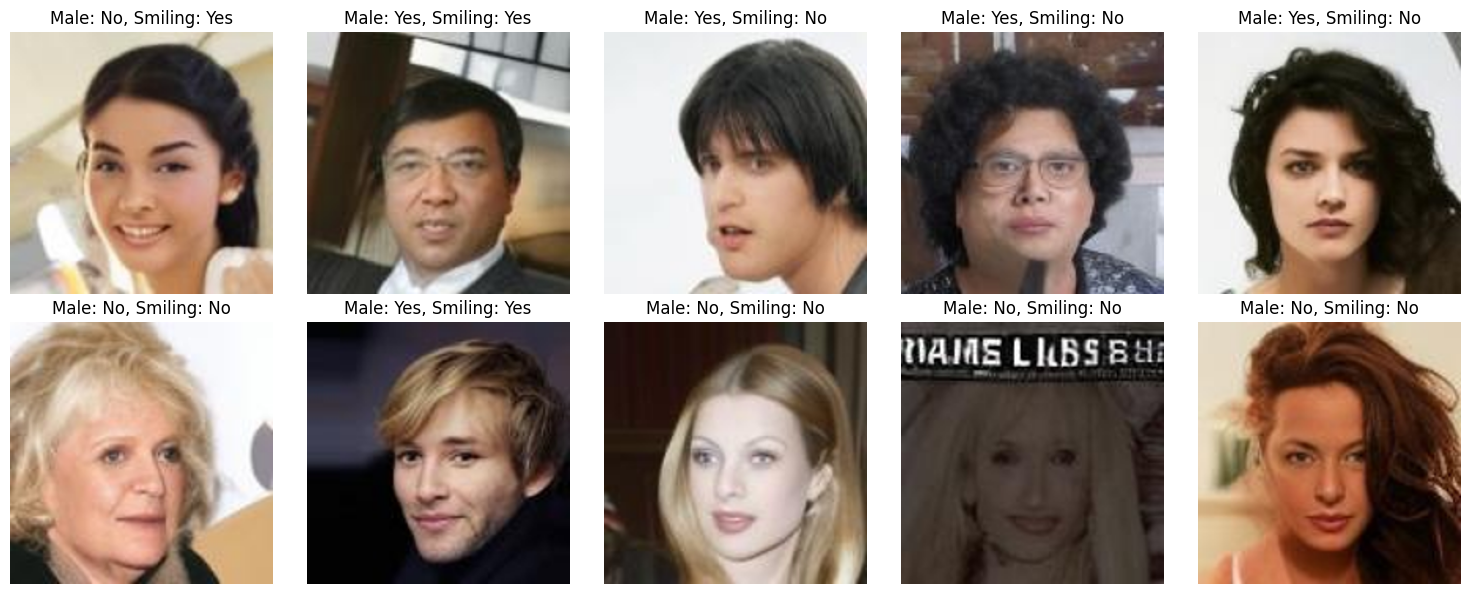

In [4]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.ravel()

random_indices = random.sample(range(len(dataset)), 10)

for i, idx in enumerate(random_indices):
    image_data = dataset[idx]
    img = image_data['image']
    male_status = "Yes" if image_data['Male'] == 1 else "No"
    smiling_status = "Yes" if image_data['Smiling'] == 1 else "No"

    display_img = img.resize((224, 224))
    axes[i].imshow(display_img)
    axes[i].set_title(f"Male: {male_status}, Smiling: {smiling_status}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [5]:
male_labels = np.array([d['Male'] for d in dataset])
smiling_labels = np.array([d['Smiling'] for d in dataset])

group1_indices = np.where((smiling_labels == 1) & (male_labels == 1))[0]
# Group 2: Smiling=1, Male=0
group2_indices = np.where((smiling_labels == 1) & (male_labels == -1))[0]
# Group 3: Smiling=0, Male=1
group3_indices = np.where((smiling_labels == -1) & (male_labels == 1))[0]
# Group 4: Smiling=0, Male=0
group4_indices = np.where((smiling_labels == -1) & (male_labels == -1))[0]

n_group1 = int(4000 * 0.15) 
n_group2 = int(4000 * 0.45) 
n_group3 = int(4000 * 0.20) 
n_group4 = int(4000 * 0.20) 

clf_train_indices_g1 = np.random.choice(group1_indices, n_group1, replace=False)
clf_train_indices_g2 = np.random.choice(group2_indices, n_group2, replace=False)
clf_train_indices_g3 = np.random.choice(group3_indices, n_group3, replace=False)
clf_train_indices_g4 = np.random.choice(group4_indices, n_group4, replace=False)

classifier_train_indices = np.concatenate([
    clf_train_indices_g1, clf_train_indices_g2, clf_train_indices_g3, clf_train_indices_g4
])

indices = np.arange(len(dataset))
remaining_indices = np.setdiff1d(indices, classifier_train_indices)

gan_train_indices = np.random.choice(remaining_indices, 4000, replace=False)
remaining_indices_after_gan = np.setdiff1d(remaining_indices, gan_train_indices)
test_indices = np.random.choice(remaining_indices_after_gan, 2000, replace=False)


In [6]:
class CelebA(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        item = self.subset[int(index)]
        image = item['image']
        male = (item['Male'] + 1) // 2  # to map them to 0 and 1
        smiling = (item['Smiling'] + 1) // 2

        # Ensure image is in PIL format for transforms
        if image.mode != 'RGB':
            image = image.convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, smiling, male

    def __len__(self):
        return len(self.subset)

classifier_train_dataset = CelebA(Subset(dataset, classifier_train_indices.tolist()), transform=data_transforms)
gan_train_dataset = CelebA(Subset(dataset, gan_train_indices.tolist()), transform=data_transforms)
test_dataset = CelebA(Subset(dataset, test_indices.tolist()), transform=data_transforms)

BATCH_SIZE = 64
classifier_train_loader = DataLoader(classifier_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
gan_train_loader = DataLoader(gan_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [7]:
def report_stats(name, indices, smiling_labels, male_labels):
    subset_smiling = smiling_labels[indices]
    subset_male = male_labels[indices]

    dist = {
        "Total": len(indices),
        "Smiling & Male": np.sum((subset_smiling == 1) & (subset_male == 1)),
        "Smiling & Female": np.sum((subset_smiling == 1) & (subset_male == -1)),
        "Not Smiling & Male": np.sum((subset_smiling == -1) & (subset_male == 1)),
        "Not Smiling & Female": np.sum((subset_smiling == -1) & (subset_male == -1)),
    }

    print(f"\nDistribution for '{name}':")
    for key, value in dist.items():
        print(f"  - {key}: {value} ({value/dist['Total']:.2%})")

report_stats("Classifier Train Set", classifier_train_indices, smiling_labels, male_labels)
report_stats("GAN Train Set", gan_train_indices, smiling_labels, male_labels)
report_stats("Test Set", test_indices, smiling_labels, male_labels)


Distribution for 'Classifier Train Set':
  - Total: 4000 (100.00%)
  - Smiling & Male: 600 (15.00%)
  - Smiling & Female: 1800 (45.00%)
  - Not Smiling & Male: 800 (20.00%)
  - Not Smiling & Female: 800 (20.00%)

Distribution for 'GAN Train Set':
  - Total: 4000 (100.00%)
  - Smiling & Male: 655 (16.38%)
  - Smiling & Female: 1268 (31.70%)
  - Not Smiling & Male: 1014 (25.35%)
  - Not Smiling & Female: 1063 (26.57%)

Distribution for 'Test Set':
  - Total: 2000 (100.00%)
  - Smiling & Male: 322 (16.10%)
  - Smiling & Female: 614 (30.70%)
  - Not Smiling & Male: 507 (25.35%)
  - Not Smiling & Female: 557 (27.85%)


In [8]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.resnet = resnet18(weights=None)
        self.feature_extractor = nn.Sequential(*list(self.resnet.children())[:-1])
        self.classifier = nn.Linear(self.resnet.fc.in_features, 1)

    def forward(self, x):
        features = self.feature_extractor(x)
        features = features.view(features.size(0), -1)
        output = self.classifier(features)
        return output

    def get_features(self, x):
        features = self.feature_extractor(x)
        return features.view(features.size(0), -1)


In [9]:
classifier = Classifier()
classifier = classifier.to(DEVICE)

Epoch 1/10 - Train Loss: 0.4764, Train Accuracy: 0.7602
Epoch 2/10 - Train Loss: 0.2686, Train Accuracy: 0.8875
Epoch 3/10 - Train Loss: 0.2074, Train Accuracy: 0.9193
Epoch 4/10 - Train Loss: 0.1554, Train Accuracy: 0.9413
Epoch 5/10 - Train Loss: 0.1332, Train Accuracy: 0.9490
Epoch 6/10 - Train Loss: 0.1019, Train Accuracy: 0.9597
Epoch 7/10 - Train Loss: 0.0962, Train Accuracy: 0.9620
Epoch 8/10 - Train Loss: 0.0842, Train Accuracy: 0.9712
Epoch 9/10 - Train Loss: 0.0384, Train Accuracy: 0.9862
Epoch 10/10 - Train Loss: 0.0553, Train Accuracy: 0.9800


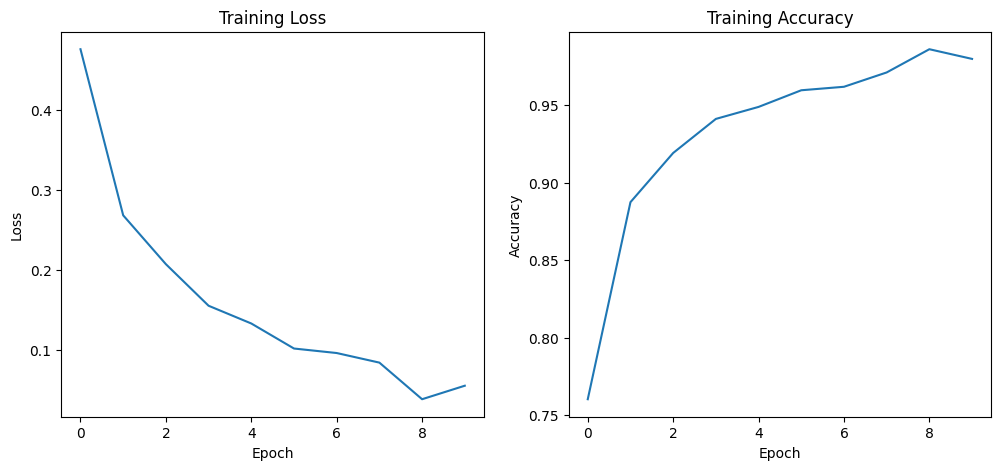

In [10]:
EPOCHS = 10
optimizer = optim.Adam(classifier.parameters(), lr=5e-4)
criterion = nn.BCELoss()

history = {'loss': [], 'accuracy': []}

for epoch in range(EPOCHS):
    classifier.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for images, smiles, _ in classifier_train_loader:
        images = images.to(DEVICE)
        smiles = smiles.to(DEVICE).unsqueeze(1).float()  

        optimizer.zero_grad()
        outputs = torch.sigmoid(classifier(images))  
        loss = criterion(outputs, smiles)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        predicted = (outputs > 0.5).int()
        total_samples += smiles.size(0)
        correct_predictions += (predicted == smiles).sum().item()

    epoch_loss = running_loss / len(classifier_train_dataset)
    epoch_acc = correct_predictions / len(classifier_train_dataset)
    history['loss'].append(epoch_loss)
    history['accuracy'].append(epoch_acc)

    print(f"Epoch {epoch+1}/{EPOCHS} - Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc:.4f}")

# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.plot(history['loss'])
ax1.set_title('Training Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax2.plot(history['accuracy'])
ax2.set_title('Training Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
plt.show()

In [20]:
classifier.eval()
test_correct, test_total = 0, 0

with torch.no_grad():
    for images, smiles, _ in test_loader:
        images = images.to(DEVICE)
        smiles = smiles.unsqueeze(1).float().to(DEVICE)
        
        outputs = torch.sigmoid(classifier(images))
        preds = (outputs > 0.5).int()
        test_correct += (preds == smiles).sum().item()
        test_total += smiles.size(0)

print(f"Test Accuracy: {test_correct / test_total:.4f}")

Test Accuracy: 0.8835


In [30]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1, bias=False), nn.BatchNorm2d(32), nn.ReLU(True), 
            nn.Conv2d(32, 64, 4, 2, 1, bias=False), nn.BatchNorm2d(64), nn.ReLU(True), 
            nn.Conv2d(64, 128, 4, 2, 1, bias=False), nn.BatchNorm2d(128), nn.ReLU(True), 
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False), nn.BatchNorm2d(64), nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 4, 2, 1, bias=False), nn.BatchNorm2d(32), nn.ReLU(True), 
            nn.ConvTranspose2d(32, 3, 4, 2, 1, bias=False), nn.Tanh() 
        )
    def forward(self, input):
        return self.main(input)


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(512, 128), nn.ReLU(True),
            nn.Linear(128, 1), nn.Sigmoid()
        )
    def forward(self, input):
        return self.main(input)

G = Generator().to(DEVICE)
D = Discriminator().to(DEVICE)

In [31]:
def entropy(p):
    p = torch.clamp(p, min=1e-8, max=1 - 1e-8) 
    return -torch.mean(p * torch.log(p) + (1 - p) * torch.log(1 - p))

Epoch 1/10 | D Loss: 0.6671 | G Loss: -0.5666 | Disc Fooling Acc: 0.4218
Epoch 2/10 | D Loss: 0.6596 | G Loss: -0.5881 | Disc Fooling Acc: 0.3965
Epoch 3/10 | D Loss: 0.6545 | G Loss: -0.5967 | Disc Fooling Acc: 0.3997
Epoch 4/10 | D Loss: 0.6544 | G Loss: -0.6048 | Disc Fooling Acc: 0.3940
Epoch 5/10 | D Loss: 0.6435 | G Loss: -0.5985 | Disc Fooling Acc: 0.3710
Epoch 6/10 | D Loss: 0.6401 | G Loss: -0.5955 | Disc Fooling Acc: 0.3685
Epoch 7/10 | D Loss: 0.6342 | G Loss: -0.5959 | Disc Fooling Acc: 0.3603
Epoch 8/10 | D Loss: 0.6377 | G Loss: -0.6002 | Disc Fooling Acc: 0.3650
Epoch 9/10 | D Loss: 0.6296 | G Loss: -0.5988 | Disc Fooling Acc: 0.3508
Epoch 10/10 | D Loss: 0.6331 | G Loss: -0.6010 | Disc Fooling Acc: 0.3605


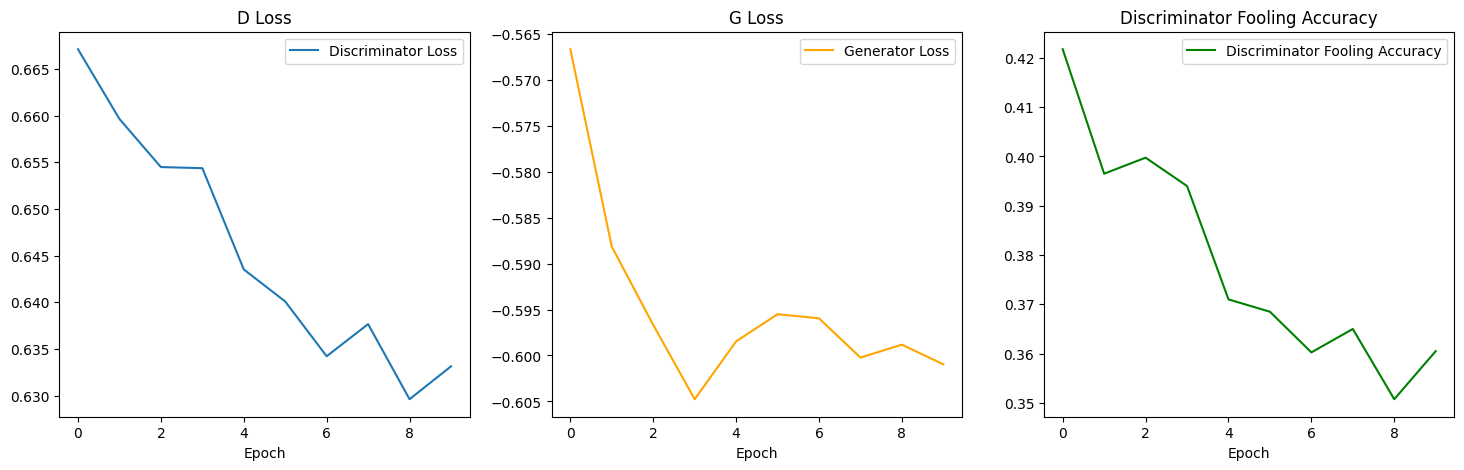

In [32]:
EPSILON = 0.05
LAMBDA_A = 0.2 
LAMBDA_B = 0.5 
optimizer_G = optim.Adam(G.parameters(), lr=5e-4)
optimizer_D = optim.Adam(D.parameters(), lr=5e-4)

g_losses, d_losses, disc_fooling_accs = [], [], []

for epoch in range(EPOCHS):
    G.train()
    D.train()
    d_loss_epoch, g_loss_epoch, total_samples, fooling = 0., 0., 0., 0.

    for images, smiles, males in gan_train_loader:
        images, smiles, males = images.to(DEVICE), smiles.to(DEVICE), males.to(DEVICE)
        male_labels_float = males.float().unsqueeze(1)
        smile_labels_float = smiles.float().unsqueeze(1)

        perturbation = G(images)
        perturbation = torch.clamp(perturbation, -EPSILON, EPSILON)
        perturbed_images = images + perturbation
        perturbed_features = classifier.get_features(perturbed_images)

        optimizer_D.zero_grad()
        d_preds = D(perturbed_features.detach())
        d_loss = nn.BCELoss()(d_preds, male_labels_float)
        d_loss.backward()
        optimizer_D.step()

        optimizer_G.zero_grad()
        d_preds_g = D(perturbed_features)

        loss_entropy = entropy(d_preds_g)
        g_loss_fair = -nn.BCELoss()(d_preds_g, male_labels_float) - LAMBDA_A * loss_entropy

        classifier_outputs = torch.sigmoid(classifier.classifier(perturbed_features))
        g_loss_target = nn.BCELoss()(classifier_outputs, smile_labels_float)

        g_loss = g_loss_fair + LAMBDA_B * g_loss_target
        g_loss.backward()
        optimizer_G.step()


        d_loss_epoch += d_loss.item()
        g_loss_epoch += g_loss.item()
        total_samples += images.size(0)

        predicted_male = (d_preds.detach() > 0.5).long() 
        fooling += (predicted_male.squeeze() != males).sum().item()
        
    avg_d_loss = d_loss_epoch / len(gan_train_loader)
    avg_g_loss = g_loss_epoch / len(gan_train_loader)
    fooling_accuracy = fooling / total_samples
    
    d_losses.append(avg_d_loss)
    g_losses.append(avg_g_loss)
    disc_fooling_accs.append(fooling_accuracy)
    
    print(f"Epoch {epoch+1}/{EPOCHS} | D Loss: {avg_d_loss:.4f} | G Loss: {avg_g_loss:.4f} | Disc Fooling Acc: {fooling_accuracy:.4f}")

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
ax1.plot(d_losses, label="Discriminator Loss")
ax1.set_title("D Loss")
ax1.set_xlabel("Epoch")
ax1.legend()
ax2.plot(g_losses, label="Generator Loss", color='orange')
ax2.set_title("G Loss")
ax2.set_xlabel("Epoch")
ax2.legend()
ax3.plot(disc_fooling_accs, label="Discriminator Fooling Accuracy", color='green')
ax3.set_title("Discriminator Fooling Accuracy")
ax3.set_xlabel("Epoch")
ax3.legend()
plt.show()

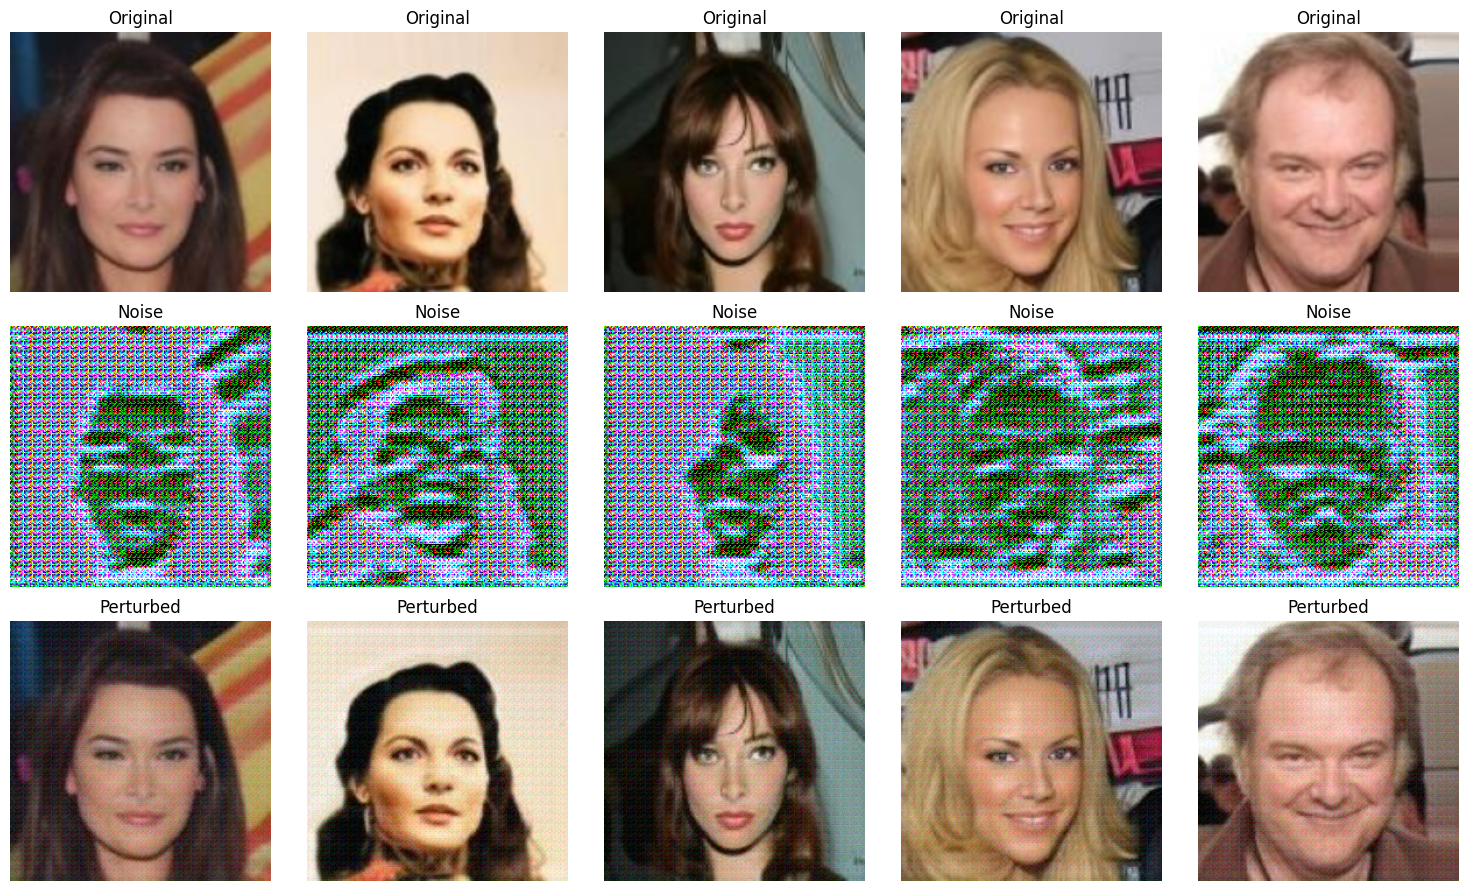

In [33]:
G.eval()
fig, axes = plt.subplots(3, 5, figsize=(15, 9))

with torch.no_grad():
    images, _, _ = next(iter(test_loader))
    images = images.to(DEVICE)

    noise = G(images)
    noise = torch.clamp(noise, -EPSILON, EPSILON)
    perturbed_images = images + noise

    
for i in range(5):
    img_orig = images[i].cpu().permute(1, 2, 0)
    axes[0, i].imshow(img_orig)
    axes[0, i].set_title("Original")
    axes[0, i].axis('off')

    noise_display = noise[i].cpu().permute(1, 2, 0)
    noise_display = (noise_display - noise_display.min()) / (noise_display.max() - noise_display.min())
    axes[1, i].imshow(noise_display)
    axes[1, i].set_title("Noise")
    axes[1, i].axis('off')

    img_pert = perturbed_images[i].cpu().permute(1, 2, 0)
    axes[2, i].imshow(img_pert.clamp(0, 1))
    axes[2, i].set_title("Perturbed")
    axes[2, i].axis('off')

plt.tight_layout()
plt.show()

In [34]:
def calculate_fairness_metrics(y_true, y_pred, sensitive_attr):
    y_true = y_true.cpu().numpy()
    y_pred = y_pred.cpu().numpy()
    sensitive_attr = sensitive_attr.cpu().numpy()

    accuracy = np.mean(y_true == y_pred)

    prob_pred1_a0 = np.mean(y_pred[sensitive_attr == 0])
    prob_pred1_a1 = np.mean(y_pred[sensitive_attr == 1])
    dp_diff = np.abs(prob_pred1_a0 - prob_pred1_a1)

    y_true_pos_indices = np.where(y_true == 1)
    y_pred_pos = y_pred[y_true_pos_indices]
    sensitive_attr_pos = sensitive_attr[y_true_pos_indices]

    prob_pred1_a0_y1 = np.mean(y_pred_pos[sensitive_attr_pos == 0]) if np.any(sensitive_attr_pos == 0) else 0
    prob_pred1_a1_y1 = np.mean(y_pred_pos[sensitive_attr_pos == 1]) if np.any(sensitive_attr_pos == 1) else 0
    eo_diff = np.abs(prob_pred1_a0_y1 - prob_pred1_a1_y1)

    return accuracy, dp_diff, eo_diff

all_y_true, all_y_pred_base, all_y_pred_faap, all_sensitive = [], [], [], []
with torch.no_grad():
    for images, smiles, males in test_loader:
        images, smiles, males = images.to(DEVICE), smiles.unsqueeze(1).float().to(DEVICE), males.unsqueeze(1).float().to(DEVICE)

        outputs_base = torch.sigmoid(classifier(images))
        predicted_base = (outputs_base > 0.5).int()

        noise = G(images)
        noise = torch.clamp(noise, -EPSILON, EPSILON)
        perturbed_images = images + noise
        outputs_faap = torch.sigmoid(classifier(perturbed_images))
        predicted_faap = (outputs_faap > 0.5).int()
 
        all_y_true.append(smiles)
        all_y_pred_base.append(predicted_base)
        all_y_pred_faap.append(predicted_faap)
        all_sensitive.append(males)

y_true = torch.cat(all_y_true)
y_pred_base = torch.cat(all_y_pred_base)
y_pred_faap = torch.cat(all_y_pred_faap)
sensitive_attr = torch.cat(all_sensitive)

acc_base, dp_base, eo_base = calculate_fairness_metrics(y_true, y_pred_base, sensitive_attr)
acc_faap, dp_faap, eo_faap = calculate_fairness_metrics(y_true, y_pred_faap, sensitive_attr)

print (f" Base Model -- Accuracy: {acc_base:.4f}, dp_diff: {dp_base:.4f}, eo_diff: {eo_base:.4f}")
print (f" FAAP Model -- Accuracy: {acc_faap:.4f}, dp_diff: {dp_faap:.4f}, eo_diff: {eo_faap:.4f}")


 Base Model -- Accuracy: 0.8835, dp_diff: 0.1558, eo_diff: 0.0841
 FAAP Model -- Accuracy: 0.9000, dp_diff: 0.1379, eo_diff: 0.0836


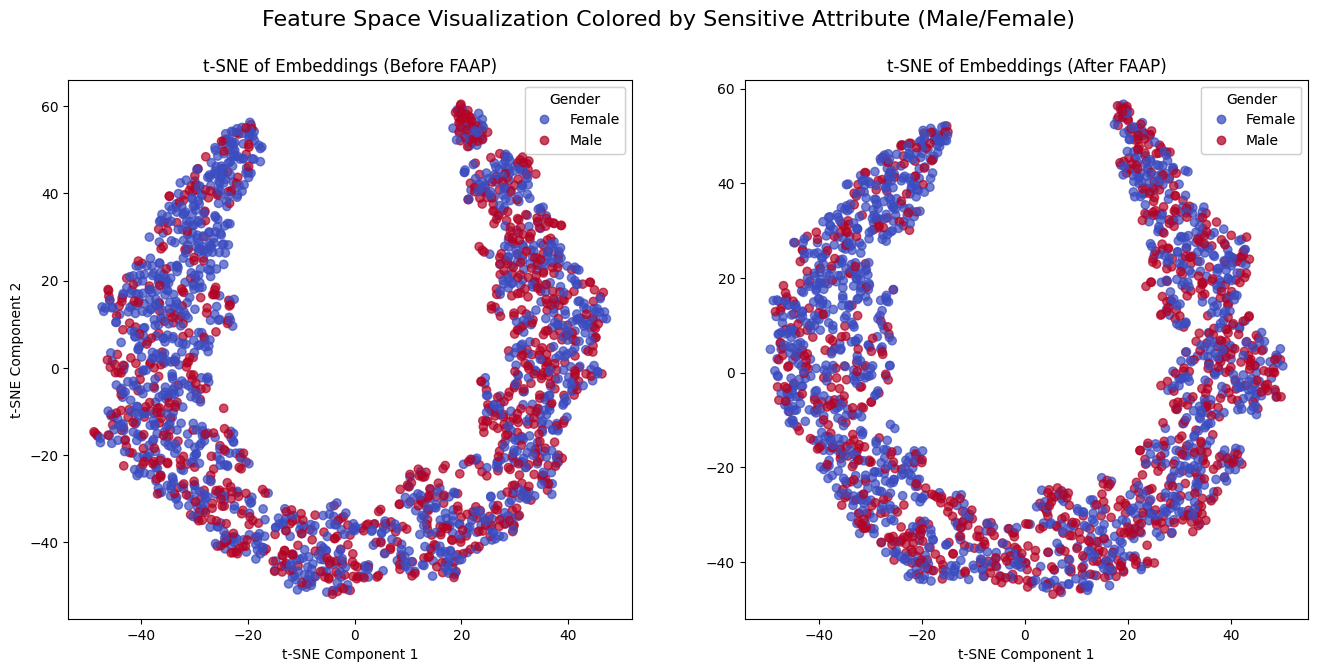

In [38]:
all_features_base, all_features_faap = [], []
all_smiles_tsne, all_males_tsne = [], []
with torch.no_grad():

    for images, smiles, males in test_loader:
        images = images.to(DEVICE)

        features_base = classifier.get_features(images)
        all_features_base.append(features_base.cpu().numpy())

        noise = G(images)
        noise = torch.clamp(noise, -EPSILON, EPSILON)
        perturbed_images = images + noise
        features_faap = classifier.get_features(perturbed_images)
        all_features_faap.append(features_faap.cpu().numpy())

        all_smiles_tsne.append(smiles.numpy())
        all_males_tsne.append(males.numpy())

features_base_np = np.concatenate(all_features_base, axis=0)
features_faap_np = np.concatenate(all_features_faap, axis=0)
labels_tsne = np.concatenate(all_smiles_tsne, axis=0)
sensitive_tsne = np.concatenate(all_males_tsne, axis=0)

tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=2000)
embeddings_base = tsne.fit_transform(features_base_np)

tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=2000)
embeddings_faap = tsne.fit_transform(features_faap_np)

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

scatter = axes[0].scatter(embeddings_base[:, 0], embeddings_base[:, 1], c=sensitive_tsne, cmap='coolwarm', alpha=0.7)
axes[0].set_title("t-SNE of Embeddings (Before FAAP)")
axes[0].set_xlabel("t-SNE Component 1")
axes[0].set_ylabel("t-SNE Component 2")
legend1 = axes[0].legend(handles=scatter.legend_elements()[0], labels=['Female', 'Male'], title="Gender")
axes[0].add_artist(legend1)

scatter = axes[1].scatter(embeddings_faap[:, 0], embeddings_faap[:, 1], c=sensitive_tsne, cmap='coolwarm', alpha=0.7)
axes[1].set_title("t-SNE of Embeddings (After FAAP)")
axes[1].set_xlabel("t-SNE Component 1")
legend2 = axes[1].legend(handles=scatter.legend_elements()[0], labels=['Female', 'Male'], title="Gender")
axes[1].add_artist(legend2)

plt.suptitle("Feature Space Visualization Colored by Sensitive Attribute (Male/Female)", fontsize=16)
plt.show()